In [21]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
# from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [22]:
# tỉ lệ 7:3
df = pd.read_csv('nvl.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df[::-1]

df = df.reset_index(drop=True) # Reset the index

In [23]:
scaler = StandardScaler()
df1 = scaler.fit_transform(np.array(df).reshape(-1, 1))


In [24]:
# Assuming df is your DataFrame containing your data
train_size = int(0.7 * len(df))

# Split the data into training and testing sets
train_data = df1[:train_size]
test_data = df1[train_size:]



In [25]:
train_data

array([[-0.59472206],
       [-0.56936762],
       [-0.5567117 ],
       ...,
       [ 1.57361516],
       [ 1.42873265],
       [ 1.4159489 ]])

In [26]:
from tbats import BATS, TBATS
# 3. Quá trình Training
y_train = np.array(train_data)

estimator = TBATS(
    seasonal_periods=[12, 30.25],
    use_arma_errors=True,
    use_box_cox=True
)
model = estimator.fit(y_train)


In [27]:
# 4. Quá trình testing
y_test = np.array(test_data)
y_pred =  model.forecast(steps=496)

In [28]:
print(y_pred[-30:])

[1.36955871 1.36955871 1.36955871 1.36955871 1.36955871 1.36955871
 1.36955871 1.36955871 1.36955871 1.36955871 1.36955871 1.36955871
 1.36955871 1.36955871 1.36955871 1.36955871 1.36955871 1.36955871
 1.36955871 1.36955871 1.36955871 1.36955871 1.36955871 1.36955871
 1.36955871 1.36955871 1.36955871 1.36955871 1.36955871 1.36955871]


In [29]:

y_next_30_days = y_pred[-30:]
y_pred = y_pred[:466]
print(y_pred)
print(y_next_30_days)

[1.41427864 1.41084669 1.40767812 1.40475272 1.40205182 1.3995582
 1.39725595 1.39513037 1.39316792 1.39135608 1.38968328 1.38813886
 1.38671296 1.38539649 1.38418105 1.38305889 1.38202284 1.38106631
 1.38018318 1.37936782 1.37861504 1.37792003 1.37727836 1.37668593
 1.37613896 1.37563397 1.37516774 1.37473728 1.37433986 1.37397294
 1.37363418 1.37332142 1.37303265 1.37276605 1.37251991 1.37229266
 1.37208285 1.37188914 1.37171029 1.37154517 1.37139273 1.37125198
 1.37112203 1.37100206 1.37089129 1.37078902 1.37069461 1.37060743
 1.37052695 1.37045265 1.37038404 1.3703207  1.37026223 1.37020824
 1.37015839 1.37011237 1.37006988 1.37003065 1.36999443 1.36996099
 1.36993012 1.36990162 1.3698753  1.369851   1.36982857 1.36980786
 1.36978874 1.36977109 1.36975479 1.36973974 1.36972585 1.36971302
 1.36970118 1.36969025 1.36968015 1.36967083 1.36966223 1.36965428
 1.36964695 1.36964018 1.36963392 1.36962815 1.36962282 1.3696179
 1.36961336 1.36960917 1.36960529 1.36960172 1.36959842 1.369595

In [30]:
train_data = df[:train_size]
test_data = df[train_size:]
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_next_30_days = scaler.inverse_transform(y_next_30_days.reshape(-1, 1))


In [31]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 43461.59540782505
RMSE: 49563.77433859389
MAPE: 2.7743318755508772


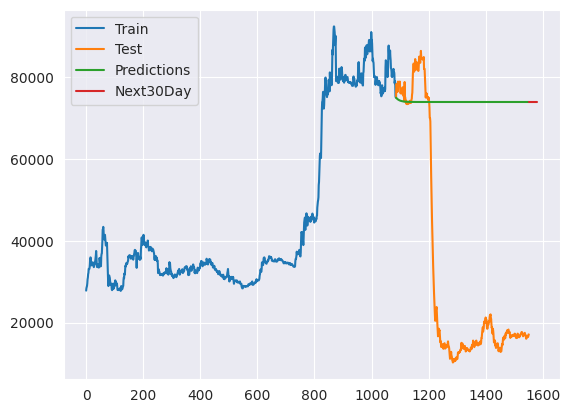

In [32]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()